We use KneiborsClassifier and face_recognition to build a model. This model will be trained by known person pictures. We use some known pictures or unknown pictures to test the trained model. As second step, we will test picture from webcam

In [1]:
# jsp_kneighbors_face3.ipynb: use MTCNN only as face detector for masked face
# Use face_recognition(dlib) to get face encording
# Use KNeighborsClassifier as predictor

import numpy as np
import os
import face_recognition as frg
from sklearn.neighbors import KNeighborsClassifier
import re
import math
import mtcnn
import matplotlib.pyplot as plt

In [2]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def show_face(img_path, location):
    pil_image = Image.open(img_path).convert("RGB")
    (top,right, bottom, left) = location

    draw = ImageDraw.Draw(pil_image)
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
    display(pil_image)


In [3]:
# We define a train function

def kntrain(X, y, neighbors, kn_alg):
    if neighbors is None:
        neighbors = int(math.sqrt(len(X)))
    klf1 = KNeighborsClassifier(algorithm=kn_alg, n_neighbors=neighbors, weights='distance')
    klf1.fit(X,y)
    return klf1            
    

In [18]:
# Use mtcnn to get face bounding boxes
# But only use bounding boxes from mtcnn to get face encoding
import cv2
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# Use MTCNN as face detector
detector = mtcnn.MTCNN()

extension = ['jpg','png','bmp','jpeg']
X =[]
y =[]

for (root,dirs,files) in os.walk('maskedface'):
    pattern = '^\w+/train/\w+'
    if re.match(pattern, root):
        print('root:',root)
        print('files:',files)
        label0 = root.split('/')[-1]
        for imgf in files:
            imgf = imgf.lower()
            if imgf.split('.')[1] in extension:
                imgpath = os.path.join(root, imgf)
                #npimg = plt.imread(imgpath)
                npimg = frg.load_image_file(imgpath, mode='RGB')
                #f_location = frg.face_locations(npimg, model='cnn')
                m_locations = detector.detect_faces(npimg)
                print('len(m_locations):',len(m_locations))
                
                #If face_recognition.face_locations() detected face box, 
                # we use the box to get encoding                
                if len(m_locations) == 1:
                    print('fpath:',imgpath)
                    x1, y1, w, h = m_locations[0]['box']
                    print('x1, y1, w, h:',x1, y1, w, h)
                    m_location = [(y1, x1+w,y1+h, x1)]
                    print('m_location:',m_location)                   
                    f_encord = frg.face_encodings(npimg,known_face_locations=m_location)[0]
                    X.append(f_encord)
                    y.append(label0)
                else:
                    print('fpath:',imgpath)
                    print('Incorrect face image!')    
            else:
                print('File $s has wrong format' % imgf)
  
klf = kntrain(X, y, neighbors=None, kn_alg='ball_tree')

root: maskedface/train/00023
files: ['001.jpg', '008.jpg', '003.jpg', '004.jpg', '002.jpg', '005.jpg', '000.jpg', '009.jpg', '006.jpg', '007.jpg']
len(m_locations): 1
fpath: maskedface/train/00023/001.jpg
x1, y1, w, h: 56 33 89 113
m_location: [(33, 145, 146, 56)]
len(m_locations): 1
fpath: maskedface/train/00023/008.jpg
x1, y1, w, h: 120 69 42 43
m_location: [(69, 162, 112, 120)]
len(m_locations): 1
fpath: maskedface/train/00023/003.jpg
x1, y1, w, h: 88 47 45 52
m_location: [(47, 133, 99, 88)]
len(m_locations): 1
fpath: maskedface/train/00023/004.jpg
x1, y1, w, h: 98 62 66 76
m_location: [(62, 164, 138, 98)]
len(m_locations): 1
fpath: maskedface/train/00023/002.jpg
x1, y1, w, h: 8 55 15 16
m_location: [(55, 23, 71, 8)]
len(m_locations): 0
fpath: maskedface/train/00023/005.jpg
Incorrect face image!
len(m_locations): 0
fpath: maskedface/train/00023/000.jpg
Incorrect face image!
len(m_locations): 0
fpath: maskedface/train/00023/009.jpg
Incorrect face image!
len(m_locations): 0
fpath: mas

In [7]:
X[1]

array([-0.18582594,  0.13987686,  0.02878121, -0.05056384, -0.17074805,
        0.05597166, -0.07287556, -0.11204351,  0.16033962, -0.10932802,
        0.20182672, -0.03063055, -0.11806309, -0.04995988, -0.04811907,
        0.18939176, -0.17375754, -0.17590684,  0.00879585, -0.02759909,
        0.09255775, -0.02153626,  0.00493145,  0.08868068, -0.17346354,
       -0.33327541, -0.07020348, -0.11992916,  0.03801182, -0.09020101,
       -0.09048025, -0.00633523, -0.15608126, -0.02067632,  0.00339392,
        0.08465922,  0.01970208, -0.05556687,  0.19070473,  0.02908353,
       -0.29107928,  0.06455263,  0.05932416,  0.26446646,  0.14406264,
       -0.022228  , -0.00217562, -0.07566015,  0.12699144, -0.14918388,
        0.0388004 ,  0.1440362 ,  0.09503871,  0.04807476,  0.01667649,
       -0.08313555,  0.03886627,  0.09270274, -0.16115737, -0.00428273,
        0.09070466, -0.06078785,  0.04253327, -0.08534614,  0.17114557,
        0.13228652, -0.04211934, -0.19156045,  0.05195266, -0.12

In [20]:
# Create test image list by using mtcnn
Xt=[]   #Test images encoding
ft=[]   #Test image file path
lt=[]   #Face location in image
for (root,dirs,files) in os.walk('maskedface/test'):
    if (files!=""):
        for f1 in files:
            label1 = f1.split('.')[0]
            f1path = os.path.join(root,f1)
            f1img = frg.load_image_file(f1path, mode='RGB')
            m_locations = detector.detect_faces(f1img)
            print('f1path:',f1path)
            print('len(m_locations):',len(m_locations))
            
            for i in range(len(m_locations)):
                #print('f1path:',f1path)
                x1, y1, w, h = m_locations[i]['box']
                m_location = [(y1, x1+w,y1+h, x1)]
                print('m_location:',m_location)                   
                f_encord = frg.face_encodings(f1img, known_face_locations=m_location)[0]               
                Xt.append(f_encord)
                lt.append(m_location)
                ft.append(f1path)
print(len(Xt))
print(len(lt))
print(ft)

f1path: maskedface/test/00003.jpg
len(m_locations): 1
m_location: [(14, 170, 95, 105)]
f1path: maskedface/test/00033.jpg
len(m_locations): 0
f1path: maskedface/test/00054.jpg
len(m_locations): 1
m_location: [(29, 157, 98, 95)]
f1path: maskedface/test/00020.jpg
len(m_locations): 1
m_location: [(27, 148, 55, 125)]
f1path: maskedface/test/00009.jpg
len(m_locations): 1
m_location: [(53, 168, 118, 112)]
f1path: maskedface/test/00013.jpg
len(m_locations): 1
m_location: [(80, 48, 119, 14)]
f1path: maskedface/test/00063.jpg
len(m_locations): 1
m_location: [(4, 218, 171, 75)]
f1path: maskedface/test/00052.jpg
len(m_locations): 1
m_location: [(17, 133, 128, 40)]
f1path: maskedface/test/00015.jpg
len(m_locations): 1
m_location: [(24, 147, 59, 116)]
f1path: maskedface/test/00108.jpg
len(m_locations): 1
m_location: [(36, 156, 79, 118)]
f1path: maskedface/test/00102.jpg
len(m_locations): 0
f1path: maskedface/test/00023.jpg
len(m_locations): 1
m_location: [(47, 133, 99, 88)]
f1path: maskedface/test/0

In [140]:
lt[1]

[(29, 157, 98, 95)]

In [21]:
# This funcation can show the real image size inline
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def show_labels_on_image2(img_path, location, label_index):
    pil_image = Image.open(img_path).convert("RGB")
    print('location:',location)
    [(top,right, bottom, left)] = location
    name = y[label_index]     # get predicted name
    #name = name.encode("UTF-8")
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
    # Define font type and size. The font file is in my ubuntu 18.04. Font size is 14
    font_file = '/usr/share/fonts/truetype/freefont/FreeSansBold.ttf'
    font = ImageFont.truetype(font_file, 16)
    text_w,text_h = font.getsize(name)
    #text_width, text_height = draw.textsize(name)
    
    draw.text((left + 5, bottom + text_h), name, font=font, fill=(000, 255, 255, 125))

    #Below will pop up a image window
    #pil_image.show()
    #Below shows image inline
    display(pil_image)


location: [(14, 170, 95, 105)]


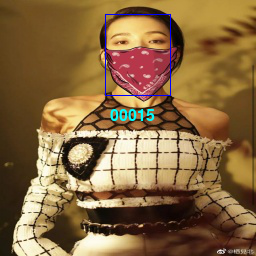

Test image: maskedface/test/00003.jpg


In [22]:
dist_threshold = 0.5
xt = Xt[0].reshape(1,-1)
closest_distance = klf.kneighbors(xt, n_neighbors=1, return_distance=True)
if closest_distance[0][0][0] <= dist_threshold :
    # Below closest_distance[1][0][0] is label (y) indices
    show_labels_on_image2(ft[0], lt[0], closest_distance[1][0][0])
    
print('Test image:', ft[0])

Test image: maskedface/test/00108.jpg
location: [(36, 156, 79, 118)]


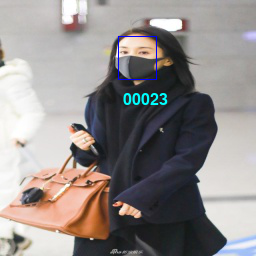

Test image: maskedface/test/00023.jpg
location: [(47, 133, 99, 88)]


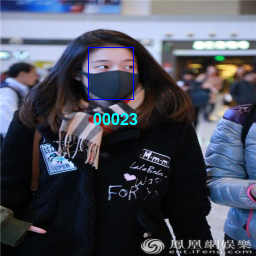

In [25]:
# Test all images in test matrix
dist_threshold = 0.35
for i in range(len(Xt)):
    xt = Xt[i].reshape(1,-1)
    closest_distance = klf.kneighbors(xt, n_neighbors=1, return_distance=True)
    if closest_distance[0][0][0] <= dist_threshold:
        # Below closest_distance[1][0][0] is label (y) indices
        print('Test image:', ft[i]) 
        show_labels_on_image2(ft[i], lt[i], closest_distance[1][0][0])
        